In [1]:
import rdflib
from rdflib import Graph
from rdflib.namespace import RDF, FOAF, TIME
from rdflib import Namespace
from rdflib import BNode, Literal
import math
import networkx as nx

# 1. Property Graph vs RDF/SPARQL

## 1. Create an RDF Graph representing the same road network and travel times

In [2]:
# Grab the definitions from https://colab.research.google.com/github/joerg84/Graph_Powered_ML_Workshop/blob/master/Graphs_Queries.ipynb#scrollTo=TSYQfoXu3b_l
cities = [
    "Inverness",
    "Aberdeen",
    "Leuchars",
    "StAndrews",
    "Edinburgh",
    "Glasgow",
    "York",
    "Cologne",
    "Carlisle",
    "Birmingham",
    "London",
    "Brussels",
    "Toronto",
    "Winnipeg",
    "Saskatoon",
    "Edmonton",
    "Jasper",
    "Vancouver"
  ];

connections = [
    ( "Inverness", "Aberdeen", 3, 2.5 ),
    ( "Aberdeen", "Leuchars", 1.5, 1 ),
    ( "Leuchars", "Edinburgh", 1.5, 3 ),
    ( "Edinburgh", "Glasgow", 1, 1 ),
    ( "Edinburgh", "York", 3.5, 4 ),
    ( "Glasgow", "Carlisle", 1, 1 ),
    ( "Carlisle", "York", 2.5, 3.5 ),
    ( "Carlisle", "Birmingham", 2.0, 1 ),
    ( "Birmingham", "London", 1.5, 2.5 ),
    ( "Leuchars", "StAndrews", 0.2, 0.2 ),
    ( "York", "London", 1.8, 2.0 ),
    ( "London", "Brussels", 2.5, 3.5 ),
    ( "Brussels", "Cologne", 2, 1.5 ),
    ( "Toronto", "Winnipeg", 36, 35 ),
    ( "Winnipeg", "Saskatoon", 12, 5 ),
    ( "Saskatoon", "Edmonton", 12, 17 ),
    ( "Edmonton", "Jasper", 6, 5 ),
    ( "Jasper", "Vancouver", 12, 13 )
]


In [3]:
# We were unable to find the predicates in the available namespaces; define the needed relations
base_url = "http://example.org/"
n = Namespace(base_url)
Trip = n.Trip
departing = rdflib.term.URIRef(base_url + "departing")
arriving = rdflib.term.URIRef(base_url + "arriving")

In [4]:
# Parse the data as triplets
g = Graph()

nodes = { n: BNode() for n in cities}

for name,node in nodes.items():
    g.add((node, RDF.type, n.City))
    g.add((node, FOAF.name, Literal(name)))

for city1, city2, time1, time2 in connections:    
    trip1 = BNode()
    trip2 = BNode()
    
    g.add((trip1, RDF.type, Trip))
    g.add((trip2, RDF.type, Trip))
    
    g.add((trip1, TIME.duration, Literal(time1)))
    g.add((trip2, TIME.duration, Literal(time2)))
    
    g.add((nodes[city1], departing, trip1))
    g.add((trip1, arriving, nodes[city2]))
    
    g.add((nodes[city2], departing, trip2))
    g.add((trip2, arriving, nodes[city1]))
    

# Print all triples
# for s, p, o in g:
#     print((s, p, o))

## 2. Implement a SPARQL query returning all cities which can be reached from London. 

In [5]:
result = g.query(
    """
    SELECT DISTINCT ?name
    WHERE
    {
        ?city1 foaf:name "London" ;
               (ex:departing/ex:arriving)+/foaf:name ?name .
    }""", 
    initNs={ 'foaf': FOAF, 'ex' : base_url }
)

for row in result:
    print(row)

(rdflib.term.Literal('Brussels'),)
(rdflib.term.Literal('London'),)
(rdflib.term.Literal('Cologne'),)
(rdflib.term.Literal('Birmingham'),)
(rdflib.term.Literal('Carlisle'),)
(rdflib.term.Literal('York'),)
(rdflib.term.Literal('Edinburgh'),)
(rdflib.term.Literal('Glasgow'),)
(rdflib.term.Literal('Leuchars'),)
(rdflib.term.Literal('Aberdeen'),)
(rdflib.term.Literal('Inverness'),)
(rdflib.term.Literal('StAndrews'),)


### Bonus: all cities which can be reached within less than 5 hours. Hint: You might want to consider property paths.

In [6]:
# result = g.query(
#     """
#     SELECT ?name2 (?dur1+?dur1 AS ?durs)
#     WHERE {
#         ?city1 foaf:name "London" ;
#                ex:departing ?trip1 .
#         ?trip1 ex:arriving ?city2 ;
#                time:duration ?dur1 .
#         ?city2 foaf:name ?name1 .

#         ?city2 ex:departing ?trip2 .
#         ?trip2 ex:arriving ?city3 ;
#                time:duration ?dur2 . 
#         ?city3 foaf:name ?name2 .
#     }
    
#     """, 
#     initNs={ 'foaf' : FOAF, 'ex': base_url, 'time' : TIME }
# )

# for row in result:
#     print(row)

## 3. Implement generic python code (i.e., the algorithms don’t have to be specified in SPARQL, but could be) for the Single Source Shortest Path algorithm and return the shortest paths to all other cities starting from London. You can choose either Dijkstra’s or Bellman-Ford’s algorithm.
We'll be implementing Dijkstra’s algorithm

In [7]:
def neighbours(name, g):
    result = g.query(
        """SELECT ?name ?dur
        WHERE
        {
            ?city1 foaf:name "%s" ;
                   ex:departing ?trip .
            ?trip ex:arriving ?city2 ;
                  time:duration ?dur .
            ?city2 foaf:name ?name .
        }""" % name, 
        initNs={ 'foaf': FOAF, 'time': TIME,  'ex': base_url }
    )
    return [
        (
            r[0].value,
            r[1].value
        ) 
        for r in result
    ]

def select_min_distance(d):
    return min(
        d.items(), 
        key=lambda x: x[1]
    )[0]

def dijkstra(
    source = "London",
    graph = g,
):
    unvisited_nodes = set(cities)
    dists = { 
        **{k: math.inf for k in unvisited_nodes}, 
        source:0
    }

    while len(unvisited_nodes) > 0:
        v = select_min_distance({k:v for k,v in dists.items() if k in unvisited_nodes})
        unvisited_nodes = unvisited_nodes.difference({v})

        for u, d in neighbours(v, graph):
            new_dist = dists[v] + d
            if new_dist < dists[u]:
                dists[u] = new_dist
    return dists

dijkstra("London", g)

{'Vancouver': inf,
 'Carlisle': 3.5,
 'Brussels': 2.5,
 'Toronto': inf,
 'Cologne': 4.5,
 'Edinburgh': 5.5,
 'Inverness': 12.0,
 'StAndrews': 8.7,
 'Winnipeg': inf,
 'Leuchars': 8.5,
 'Saskatoon': inf,
 'York': 2.0,
 'Edmonton': inf,
 'Glasgow': 4.5,
 'Aberdeen': 9.5,
 'Birmingham': 2.5,
 'London': 0,
 'Jasper': inf}

# 2. Pagerank

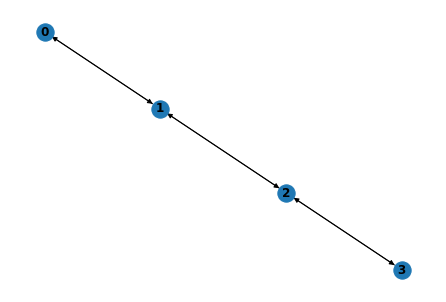

In [8]:
G = nx.DiGraph(nx.path_graph(4))
nx.draw(G, with_labels=True, font_weight='bold')

In [9]:
def input_edges(node, G):
    return [u for u,v in G.edges if v == node]

def num_output_edges(node, G):
    return len(G.edges(node))

def pagerank(G, alpha = 0.15, eps = 1e-6):
    M = {k:1 for k in G.nodes()}
    R = {k:0 for k in G.nodes()}
    err = math.inf
    while err > eps:
        R_prev = {k:v for k,v in R.items()}
        for i in G.nodes():
            R[i] = alpha + (1-alpha)*sum([M[j] for j in input_edges(i, G)])
            M[i] = (R[i] / num_output_edges(i, G)) #if num_output_edges(node, G) > 0 else 0
        err = sum([abs(R[i] - R_prev[i]) for i in G.nodes()])
    
    # Normalize
    R_sum = sum([v for v in R.values()])
    R = {k:v/R_sum for k,v in R.items()}
    return R
        
pagerank(G)

{0: 0.17543861892113416,
 1: 0.3245614246214016,
 2: 0.3245613899708173,
 3: 0.17543856648664707}

In [10]:
# Check with nx implementation
nx.pagerank(G)

{0: 0.17543839772251535,
 1: 0.32456160227748465,
 2: 0.32456160227748465,
 3: 0.17543839772251535}